In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


I realize that the number of slices is not constant; therefore, with the code below I find the minimum value of slices with which I will then unify the dataset

In [2]:
import nibabel as nib
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from skimage.io import imread, imshow
from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt


Found GPU at: /device:GPU:0


In [3]:
PATH = '/content/drive/MyDrive/Progetto/kits19/data'
DATA_CT = '/imaging.nii.gz'
SEGM_CT = '/segmentation.nii.gz'

START_TRAIN = 0
END_TRAIN = 75

START_TEST = 75
END_TEST = 100

DATA_AUGM = False



In [ ]:
min_slice = 50000
case_val = 0
img = []
img_path = DATA_CT

for i in range(0, 300):
    img = nib.load(PATH+'/case_'+f'{i:05d}'+img_path)
    slice_val = img.shape[0]
    if min_slice >= slice_val:
      case_val = i
      min_slice = slice_val


print(min_slice)
print(case_val)

29
61


Therefore the minimum number of slices will be 29. The size of the images is 512x512 in all cases but 161 which is 256x256. In addition, only the first 209 patients have a mask. So, for simplicity, I'll consider only the first 100 patients, 75% for training and 25% for testing. I'll also consider an arbitrary subset of slices for limitations due to performance with Colab Free

In [4]:
def get_images(start, stop, img_path):
  images = []


  for cases in range(start, stop):
    # loading the images
    img = nib.load(PATH+'/case_'+f'{cases:05d}'+img_path)
    img = img.get_fdata()

    #for hardware reasons I'm resampling the images with size 256x256 and a number of slices equal to the minimum present in the set (29 case_00061)
    img = resize(img, (29,256,256), order=1, preserve_range=True)


    # I add them to the set of images by normalizing them at the same time
    for j in range(0, img.shape[0]):
      images.append(img[j, :, :]/255)
    print(cases)

  return images


In [5]:
print('-------------------')
print('Getting training dataset')
trainSet_ct = np.array(get_images(START_TRAIN, END_TRAIN, DATA_CT))
print('Loading of the training set done!')
trainSet_seg = np.array(get_images(START_TRAIN, END_TRAIN, SEGM_CT))
# cleaning the mask
trainSet_seg[trainSet_seg > 0.001] = 1
trainSet_seg[trainSet_seg <= 0.001] = 0
print('Loading of the mask done!')
print('-------------------')

-------------------
Getting training dataset
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Loading of the training set done!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Loading of the mask done!
-------------------


Below some debugging code to see if has worked

Dataset length: 2175


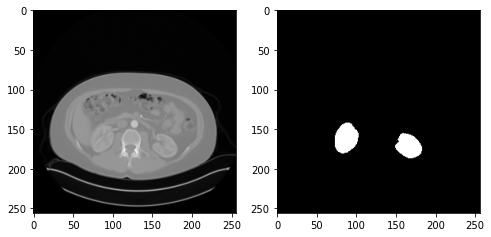

In [6]:
val = 10
print("Dataset length:", len(trainSet_ct))
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(trainSet_ct[val], cmap = 'gray')
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(trainSet_seg[val], cmap = 'gray')

In [8]:
print('-------------------')
print('Getting testing dataset')
testCT = np.array(get_images(START_TEST, END_TEST, DATA_CT))
print('Loading of the testing set done!')
testLabel = np.array(get_images(START_TEST, END_TEST, SEGM_CT))
print('Loading of the mask done!')
print('-------------------')

-------------------
Getting testing dataset
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Loading of the testing set done!
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Loading of the mask done!
-------------------


Down there the Unet borrowed from the following link -> https://www.kaggle.com/code/shakshyathedetector/image-segmentation-using-u-net


In [9]:
def uNet():

    #Contraction path
    # 256x256
    c1 = tf.keras.layers.Conv2D(
        16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(256, 256, 1))(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c1)

    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    # 128x128
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p1)

    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c2)

    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    # 64x64
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c3)

    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    # 32x32
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c4)

    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    # 16x16
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(
        128, (2, 2), strides=(2, 2), padding='same')(c5)
    # 32x32
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c6)

    # 64x64
    u7 = tf.keras.layers.Conv2DTranspose(
        64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c7)

    # 128x128
    u8 = tf.keras.layers.Conv2DTranspose(
        32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c8)

    # 256x256
    u9 = tf.keras.layers.Conv2DTranspose(
        16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return outputs

Then we train the model with our dataset

In [10]:
print('-----------------------')
print('Building the model...')
inputs = tf.keras.layers.Input((256, 256, 1))

outputs = uNet()

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

#The following function prints the summary of the model parameters       
model.summary()

#Modelcheckpoint -> allows you to save the state of the model 
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_bioimage.h5', verbose=1, save_best_only=True)

# With 'EarlyStopping' stop training if, after "patience" epoch, validation loss does not improve 
# With' TensorBoard' we get info about training

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

results = model.fit(trainSet_ct, trainSet_seg, validation_split=0.1,
                    batch_size=8, epochs=5, callbacks=callbacks)



-----------------------
Building the model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )               

In [11]:
preds_train = model.predict(trainSet_ct, verbose=1)
preds_test = model.predict(testCT, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

23/23 [==============================] - 3s 134ms/step


Now we will test if the training has worked

In [12]:
import random

seed = 42
np.random.seed = seed
idx = random.randint(0, len(trainSet_ct))
idy = random.randint(0, len(trainSet_seg))


In [13]:
def modelCheck(trainOriginals, trainLabels, preds_train_t):

    ix = random.randint(0, len(preds_train_t))
    # Load the original image, label, and predicted label
    orig_image = trainOriginals[ix]
    orig_label = trainLabels[ix]
    pred_label = preds_train_t[ix][:, :, 0]

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the original image in the first subplot
    axs[0].imshow(orig_image)
    axs[0].set_title("Original image")

    # Display the original label in the second subplot
    axs[1].imshow(orig_label)
    axs[1].set_title("Original label")

    # Display the predicted label in the third subplot
    axs[2].imshow(pred_label)
    axs[2].set_title("Predicted label")

    plt.show()

Let's see first with the training set and then we check the testing set to see if the model works because of overfitting or not

--------------------
Training check: 


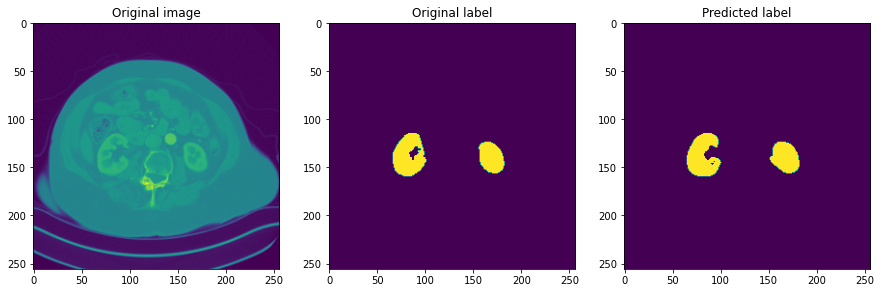

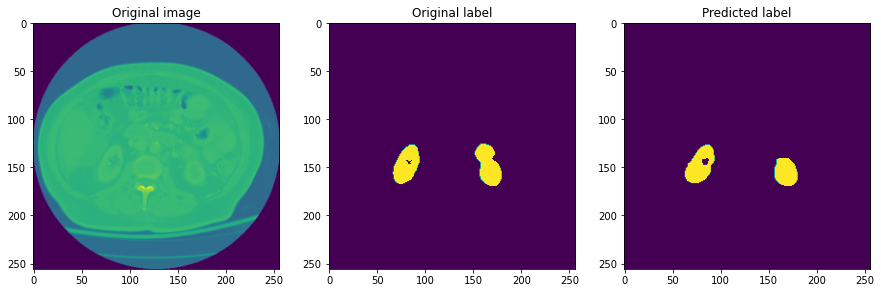

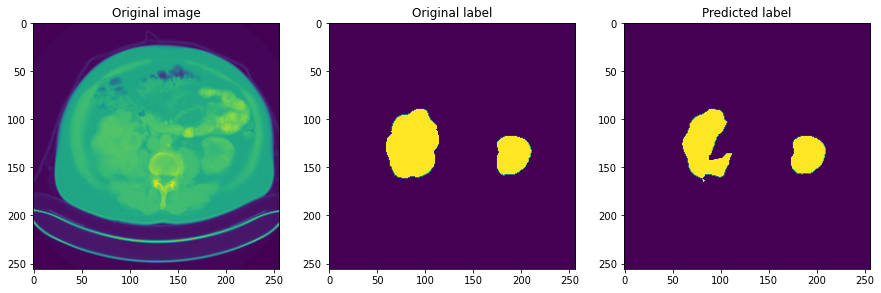

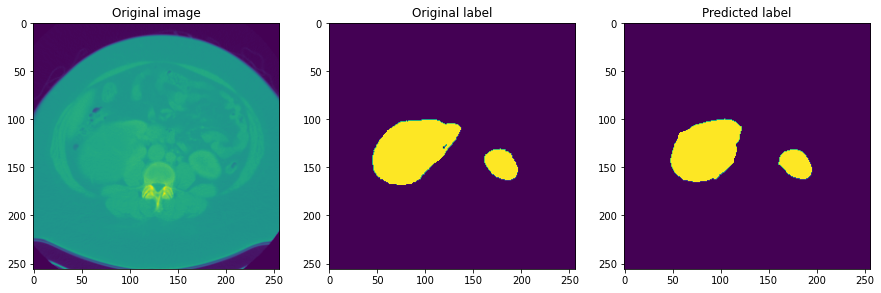

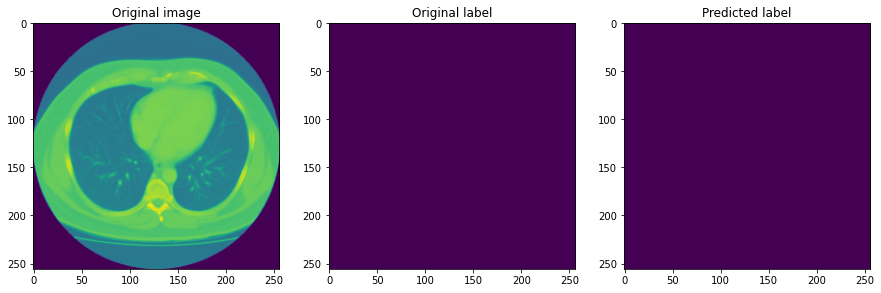

-------------------
///////////////////
-------------------
 
Training check: 


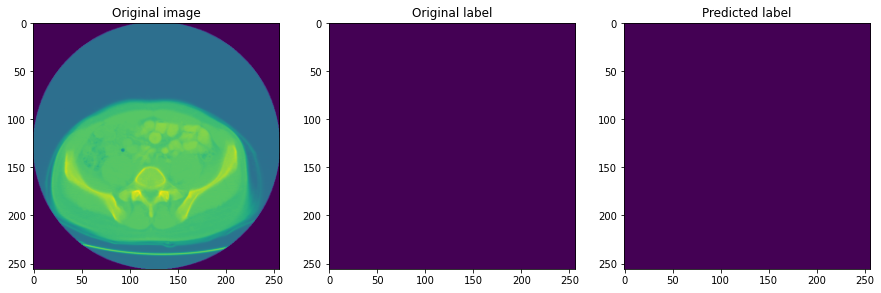

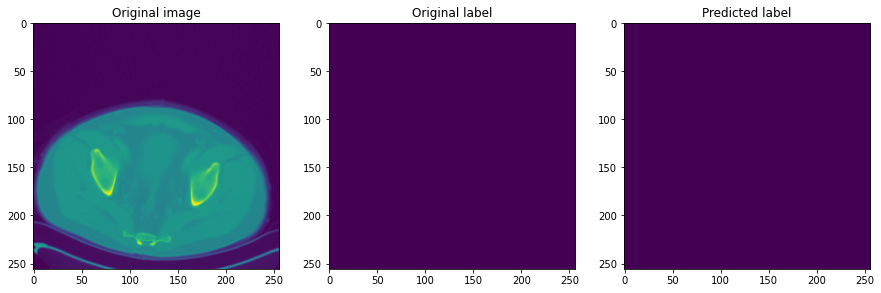

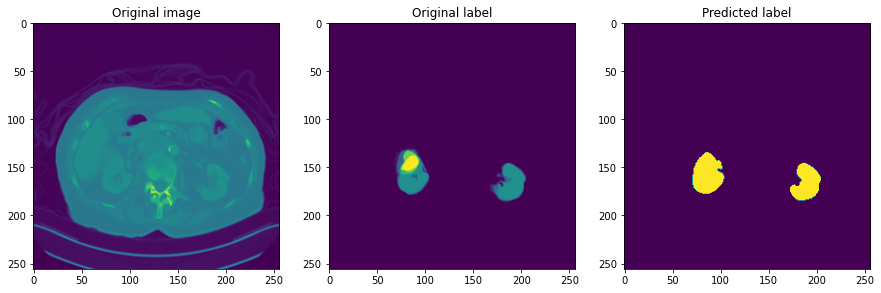

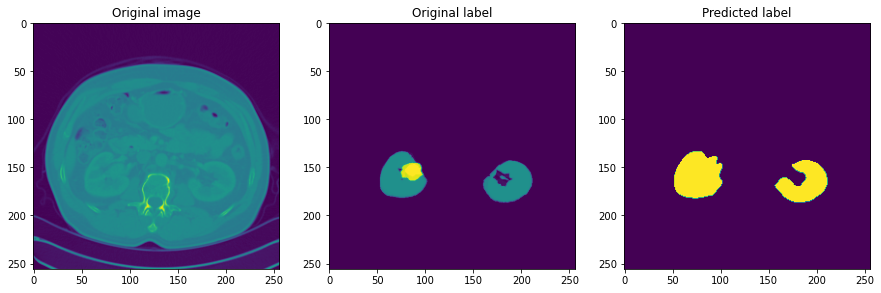

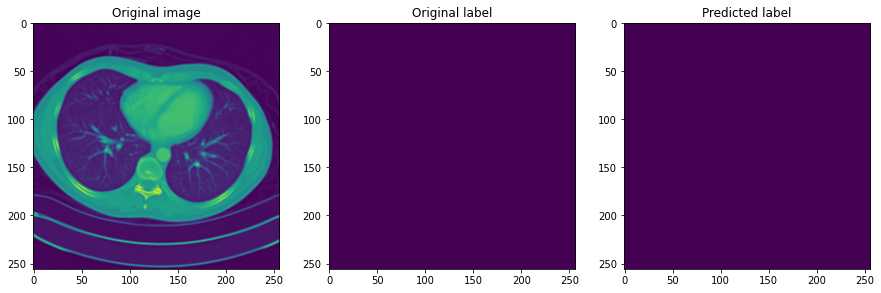

In [16]:
# Check on some random training samples
print('--------------------')
print('Training check: ')
for i in range(5):
  modelCheck(trainSet_ct, trainSet_seg, preds_train_t)
print('-------------------')
print('///////////////////')
print('-------------------')
print(' ')
print('Training check: ')
for i in range(5):
  modelCheck(testCT, testLabel, preds_test_t)